<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/TextualInversion_StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textual Inversion Background



---










In [ ]:
!pip install -U tensorflow -q
!pip install keras-cv==0.6.0 -q
!pip install keras-core -q

import math
import string
import random
import keras_cv
import numpy as np
import tensorflow as tf
from keras_cv import layers as cv_layers
from keras_cv.models.stable_diffusion import NoiseScheduler
from tensorflow import keras
import matplotlib.pyplot as plt
from keras_core import ops
from IPython.display import Image as IImage
from PIL import Image

stable_diffusion = keras_cv.models.StableDiffusion()

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


# Assembling a text-image pair dataset






In [ ]:
def assemble_image_dataset(urls):
    # Fetch all remote files
    files = [tf.keras.utils.get_file(origin=url) for url in urls]

    # Resize images
    resize = keras.layers.Resizing(height=512, width=512, crop_to_aspect_ratio=True)
    images = [keras.utils.load_img(img) for img in files]
    images = [keras.utils.img_to_array(img) for img in images]
    images = np.array([resize(img) for img in images])

    # The StableDiffusion image encoder requires images to be normalized to the
    # [-1, 1] pixel value range
    images = images / 127.5 - 1

    # Create the tf.data.Dataset
    image_dataset = tf.data.Dataset.from_tensor_slices(images)

    # Shuffle and introduce random noise
    image_dataset = image_dataset.shuffle(50, reshuffle_each_iteration=True)
    image_dataset = image_dataset.map(
        cv_layers.RandomCropAndResize(
            target_size=(512, 512),
            crop_area_factor=(0.8, 1.0),
            aspect_ratio_factor=(1.0, 1.0),
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    image_dataset = image_dataset.map(
        cv_layers.RandomFlip(mode="horizontal"),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return image_dataset

MAX_PROMPT_LENGTH = 77
placeholder_token = "<kandandinsky-style>"


def pad_embedding(embedding):
    return embedding + (
        [stable_diffusion.tokenizer.end_of_text] * (MAX_PROMPT_LENGTH - len(embedding))
    )


stable_diffusion.tokenizer.add_tokens(placeholder_token)


def assemble_text_dataset(prompts):
    prompts = [prompt.format(placeholder_token) for prompt in prompts]
    embeddings = [stable_diffusion.tokenizer.encode(prompt) for prompt in prompts]
    embeddings = [np.array(pad_embedding(embedding)) for embedding in embeddings]
    text_dataset = tf.data.Dataset.from_tensor_slices(embeddings)
    text_dataset = text_dataset.shuffle(100, reshuffle_each_iteration=True)
    return text_dataset

In [ ]:
def assemble_dataset(urls, prompts):
    image_dataset = assemble_image_dataset(urls)
    text_dataset = assemble_text_dataset(prompts)
    # the image dataset is quite short, so we repeat it to match the length of the
    # text prompt dataset
    image_dataset = image_dataset.repeat()
    # we use the text prompt dataset to determine the length of the dataset.  Due to
    # the fact that there are relatively few prompts we repeat the dataset 5 times.
    # we have found that this anecdotally improves results.
    text_dataset = text_dataset.repeat(5)
    return tf.data.Dataset.zip((image_dataset, text_dataset))

In [ ]:
single_ds = assemble_dataset(
    urls=[
        "https://i.imgur.com/I8jpVNU.jpg",
        "https://i.imgur.com/o45x0zX.jpg",
        "https://i.imgur.com/FNmAhA5.jpg",
    ],
    prompts=[
    'a painting in the style of {}',
    'a rendering in the style of {}',
    'a cropped painting in the style of {}',
    'the painting in the style of {}',
    'a clean painting in the style of {}',
    'a picture in the style of {}',
    'a cool painting in the style of {}',
    'a close-up painting in the style of {}',
    'a bright painting in the style of {}',
    'a cropped painting in the style of {}',
    'a good painting in the style of {}',
    'a close-up painting in the style of {}',
    'a rendition in the style of {}',
    'a nice painting in the style of {}',
    'a small painting in the style of {}',
    'a weird painting in the style of {}',
    'a large painting in the style of {}',
    ],
)
train_ds = single_ds.batch(1).shuffle(
    single_ds.cardinality(), reshuffle_each_iteration=True
)

# Adding a new token to the text encoder


In [ ]:
tokenized_initializer = stable_diffusion.tokenizer.encode("painting")[1]

# creating our trainable token vector (i.e. v*)
new_weights = stable_diffusion.text_encoder.layers[2].token_embedding(
    tf.constant(tokenized_initializer)
)

# Get len of .vocab instead of tokenizer
new_vocab_size = len(stable_diffusion.tokenizer.vocab)

# The embedding layer is the 2nd layer in the text encoder
old_token_weights = stable_diffusion.text_encoder.layers[
    2
].token_embedding.get_weights()
old_position_weights = stable_diffusion.text_encoder.layers[
    2
].position_embedding.get_weights()

old_token_weights = old_token_weights[0]
new_weights = np.expand_dims(new_weights, axis=0)

# combining our traininable vector with old embedding weights
new_weights = np.concatenate([old_token_weights, new_weights], axis=0)

In [ ]:
# Have to set download_weights False so we can init (otherwise tries to load weights)
new_encoder = keras_cv.models.stable_diffusion.TextEncoder(
    keras_cv.models.stable_diffusion.stable_diffusion.MAX_PROMPT_LENGTH,
    vocab_size=new_vocab_size,
    download_weights=False,
)
for index, layer in enumerate(stable_diffusion.text_encoder.layers):
    # Layer 2 is the embedding layer, so we omit it from our weight-copying
    if index == 2:
        continue
    new_encoder.layers[index].set_weights(layer.get_weights())

# the new embedding layer with our trainable token vector included
new_encoder.layers[2].token_embedding.set_weights([new_weights])
new_encoder.layers[2].position_embedding.set_weights(old_position_weights)

stable_diffusion._text_encoder = new_encoder
stable_diffusion._text_encoder.compile(jit_compile=True)


In [ ]:
stable_diffusion.diffusion_model.trainable = False
stable_diffusion.decoder.trainable = False
stable_diffusion.text_encoder.trainable = True

stable_diffusion.text_encoder.layers[2].trainable = True


def traverse_layers(layer):
    if hasattr(layer, "layers"):
        for layer in layer.layers:
            yield layer
    if hasattr(layer, "token_embedding"):
        yield layer.token_embedding
    if hasattr(layer, "position_embedding"):
        yield layer.position_embedding


for layer in traverse_layers(stable_diffusion.text_encoder):
    if isinstance(layer, keras.layers.Embedding) or "clip_embedding" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

new_encoder.layers[2].position_embedding.trainable = False

# Reloading Weights and Generating Images

50/50 [==============================] - 50s 1s/step


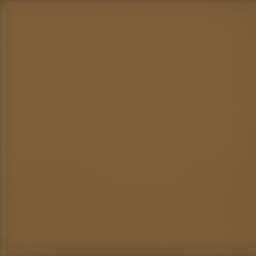

In [ ]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.axis("off")
        plt.savefig(''.join(random.choices(string.ascii_uppercase + string.digits, k=10))+'.png', bbox_inches='tight')

def export_as_gif(filename, images, frames_per_second=30, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

def downsample(image):
  half = 0.5
  size = [int(half * s) for s in image.size]
  return image.resize(size)


pretrained=np.load("/content/drive/MyDrive/pretrained_two.npy", allow_pickle=True)
stable_diffusion.text_encoder.layers[2].set_weights(pretrained)
prompt =  f"rendering of Russia in style of {placeholder_token}"
encoding=stable_diffusion.encode_text(prompt)
noise = tf.random.stateless_normal((512 // 8, 512 // 8, 4), seed=[42, 42])

cfg_scale = 7.5
walk_steps = 60
batch_size = 3
batches = walk_steps // batch_size
min_frequency = 0
max_frequency = 1

walk_noise_x = tf.random.normal(noise.shape, dtype="float64")
walk_noise_y = tf.random.normal(noise.shape, dtype="float64")

frequencies = ops.linspace(min_frequency,max_frequency, walk_steps)
noise_x_one = ops.tensordot(frequencies, walk_noise_x, axes=0)
noise_y_one = ops.tensordot(frequencies, walk_noise_y, axes=0)
noise = ops.add(noise_x_one, noise_y_one)
batched_noise = ops.split(noise, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in stable_diffusion.generate_image(
            encoding,
            batch_size=batch_size,
            num_steps=50,
            diffusion_noise=batched_noise[batch],
            unconditional_guidance_scale = cfg_scale
        )
    ]

gif_maker = []
for i in range(0,len(images)):
  # plot_images(images[i])
  gif_maker.append(downsample(images[i]))

export_as_gif("exp_two.gif", gif_maker, frames_per_second=10, rubber_band=True)
IImage("exp_two.gif")